<a href="https://colab.research.google.com/github/pathdata/ImageAnnotator/blob/master/example_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Morpho-molecular pathology maps

## Introduction

We developed a robust and automated pipeline to estimate and quantify morphological as well as  molecular signatures of various cell types in pathological tissues at the single-cell resolution level. For molecular maps, For morphological maps, the new features are computationally extracted and then weighted to assess their importance to capture the overall variability of the data. We believe studying both structural and functional heterogeneity of the cell will provide new insights into how neurons and astrocytes are organized into distinct lineage-associated layers.

## Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  neuron_data.tsv	sample_data


In [ ]:
!cd drive/MyDrive/neuron_classification && ls

neuron_data.tsv


### Preparation

We start by importing the initially required libraries and loading the dataset with Pandas.

In [ ]:
# Import Pandas and Numpy so that we can work on the tabular data
import pandas as pd
import numpy as np

# Import Matplotlib and Seaborn for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Read the tsv file via read_csv function of Pandas with the tab character as the delimiter
df = pd.read_csv('drive/MyDrive/neuron_classification/neuron_data.tsv', sep='\t')

In [ ]:
df.head()

,TileRow,TileColumn,Field,PositionX_m,PositionY_m,Neurons_ROINo,Neurons_NeuronArea_m,Neurons_NeuronRoundness,Neurons_NeuronRatioWidthToLength,Neurons_NeuronAlexa700IntensityMean,Neurons_NeuronAlexa700IntensitySum,Neurons_NeuronAlexa700IntensityContrast,Neurons_NeuronDAPIIntensityMean,Neurons_NeuronDAPIIntensityMedian,Neurons_NeuronDAPIIntensityMaximum,Neurons_NeuronDAPIIntensityMinimum,Neurons_NeuronDAPIIntensitySum,Neurons_NeuronDAPIIntensityContrast,Neurons_ObjectNoInNeunNuclei,Neurons_RegressionA_B,Spotcounts_Rorb,Spotcounts_Ctip2,Spotcounts_Cux2,Spotcounts_Foxp2,file,slide,layer
0,1,2,11,6191.68,-1646.89,2,126.3260,0.925504,0.759870,1352.150,1911940,0.565114,1088.97,1048.70,2562.85,220.072,1539800.0,0.235723,2,-2.12337,2,10,17,30,005R_M5_E1_Neurons,005R,L6
1,1,2,11,6388.98,-1643.13,6,62.8056,0.834710,0.522438,1637.100,1150880,0.649193,1255.98,1192.16,3570.58,233.447,882951.0,0.683758,3,-2.05944,1,16,10,10,005R_M5_E1_Neurons,005R,L6
2,1,2,11,6264.34,-1646.15,3,92.0196,0.987139,0.791327,1107.800,1141030,0.515607,1199.08,1167.66,2867.04,371.420,1235060.0,0.563639,5,-2.40867,6,6,9,11,005R_M5_E1_Neurons,005R,L6
3,1,2,11,6352.71,-1646.58,5,155.4510,0.838467,0.614839,1090.790,1897970,0.461783,1452.20,1523.59,3162.85,285.045,2526820.0,0.462379,7,-1.37236,2,50,12,51,005R_M5_E1_Neurons,005R,L6
4,1,2,11,6214.11,-1647.38,8,89.9648,0.942779,0.698430,860.581,866605,0.331958,1557.80,1447.21,3925.66,406.521,1568710.0,0.466981,8,-2.10750,2,4,14,16,005R_M5_E1_Neurons,005R,L6


Now that our dataset is loaded, let's see what features we have in it.

In [ ]:
df.columns

Index(['TileRow', 'TileColumn', 'Field', 'PositionX_m', 'PositionY_m',
       'Neurons_ROINo', 'Neurons_NeuronArea_m', 'Neurons_NeuronRoundness',
       'Neurons_NeuronRatioWidthToLength',
       'Neurons_NeuronAlexa700IntensityMean',
       'Neurons_NeuronAlexa700IntensitySum',
       'Neurons_NeuronAlexa700IntensityContrast',
       'Neurons_NeuronDAPIIntensityMean', 'Neurons_NeuronDAPIIntensityMedian',
       'Neurons_NeuronDAPIIntensityMaximum',
       'Neurons_NeuronDAPIIntensityMinimum', 'Neurons_NeuronDAPIIntensitySum',
       'Neurons_NeuronDAPIIntensityContrast', 'Neurons_ObjectNoInNeunNuclei',
       'Neurons_RegressionA_B', 'Spotcounts_Rorb', 'Spotcounts_Ctip2',
       'Spotcounts_Cux2', 'Spotcounts_Foxp2', 'file', 'slide', 'layer'],
      dtype='object')

'layer' is our target variable. There seems to be some information about the image patch that each neuron is seen in, coordinates of the neuron, some geometric and chromatic features about the neuron, information about the slide and file. We need to check out the information about spots and regression.

Let's see the data type of each feature.

In [ ]:
df.dtypes

TileRow                                      int64
TileColumn                                   int64
Field                                        int64
PositionX_m                                float64
PositionY_m                                float64
Neurons_ROINo                                int64
Neurons_NeuronArea_m                       float64
Neurons_NeuronRoundness                    float64
Neurons_NeuronRatioWidthToLength           float64
Neurons_NeuronAlexa700IntensityMean        float64
Neurons_NeuronAlexa700IntensitySum           int64
Neurons_NeuronAlexa700IntensityContrast    float64
Neurons_NeuronDAPIIntensityMean            float64
Neurons_NeuronDAPIIntensityMedian          float64
Neurons_NeuronDAPIIntensityMaximum         float64
Neurons_NeuronDAPIIntensityMinimum         float64
Neurons_NeuronDAPIIntensitySum             float64
Neurons_NeuronDAPIIntensityContrast        float64
Neurons_ObjectNoInNeunNuclei                 int64
Neurons_RegressionA_B          

Our target variable 'layer' is of 'object' type. Which means we need to do some kind of encoding to ingest this data with our machine learning models. X and Y position values may give us enough information to infer neighbors of each cell.

This way we can actually use a machine learning algorithm like K-nearest neighbor to quickly predict the layer of each neuron. This method would not be practical however, because we are not going to have layer and exact position information of the neighboring cells at test time.

Another way this information can help us is in terms of local context. Just like convolutional neural networks use local context for evaluation of each pixel, we can use information about each neuron in a certain coordinate range as another feature to give our machine learning algorithm more context information.

To get a sense for the data, let's look at the first and last 10 rows.

In [ ]:
df.head(10)

,TileRow,TileColumn,Field,PositionX_m,PositionY_m,Neurons_ROINo,Neurons_NeuronArea_m,Neurons_NeuronRoundness,Neurons_NeuronRatioWidthToLength,Neurons_NeuronAlexa700IntensityMean,Neurons_NeuronAlexa700IntensitySum,Neurons_NeuronAlexa700IntensityContrast,Neurons_NeuronDAPIIntensityMean,Neurons_NeuronDAPIIntensityMedian,Neurons_NeuronDAPIIntensityMaximum,Neurons_NeuronDAPIIntensityMinimum,Neurons_NeuronDAPIIntensitySum,Neurons_NeuronDAPIIntensityContrast,Neurons_ObjectNoInNeunNuclei,Neurons_RegressionA_B,Spotcounts_Rorb,Spotcounts_Ctip2,Spotcounts_Cux2,Spotcounts_Foxp2,file,slide,layer
0,1,2,11,6191.68,-1646.89,2,126.3260,0.925504,0.759870,1352.150,1911940,0.565114,1088.97,1048.70,2562.85,220.072,1539800.0,0.235723,2,-2.12337,2,10,17,30,005R_M5_E1_Neurons,005R,L6
1,1,2,11,6388.98,-1643.13,6,62.8056,0.834710,0.522438,1637.100,1150880,0.649193,1255.98,1192.16,3570.58,233.447,882951.0,0.683758,3,-2.05944,1,16,10,10,005R_M5_E1_Neurons,005R,L6
2,1,2,11,6264.34,-1646.15,3,92.0196,0.987139,0.791327,1107.800,1141030,0.515607,1199.08,1167.66,2867.04,371.420,1235060.0,0.563639,5,-2.40867,6,6,9,11,005R_M5_E1_Neurons,005R,L6
3,1,2,11,6352.71,-1646.58,5,155.4510,0.838467,0.614839,1090.790,1897970,0.461783,1452.20,1523.59,3162.85,285.045,2526820.0,0.462379,7,-1.37236,2,50,12,51,005R_M5_E1_Neurons,005R,L6
4,1,2,11,6214.11,-1647.38,8,89.9648,0.942779,0.698430,860.581,866605,0.331958,1557.80,1447.21,3925.66,406.521,1568710.0,0.466981,8,-2.10750,2,4,14,16,005R_M5_E1_Neurons,005R,L6
5,1,2,11,6332.43,-1647.41,4,125.9690,0.713025,0.441308,847.696,1195250,0.370373,1127.99,1163.33,2738.11,276.901,1590460.0,0.262584,9,-1.07277,0,20,19,37,005R_M5_E1_Neurons,005R,L6
6,1,2,11,6359.43,-1652.47,5,63.6990,0.917746,0.653802,1654.340,1179540,0.640091,1099.77,1133.78,3023.65,253.271,784139.0,0.628471,12,-2.40583,0,22,3,18,005R_M5_E1_Neurons,005R,L6
7,1,2,11,6188.03,-1658.13,2,121.9480,0.867663,0.708085,1375.540,1877620,0.596262,1411.75,1393.03,3747.49,281.893,1927040.0,0.107602,14,-2.03008,2,22,13,39,005R_M5_E1_Neurons,005R,L6
8,1,2,11,6263.90,-1665.91,13,111.5850,0.963758,0.683486,1029.030,1285250,0.473582,1707.46,1793.85,3036.14,279.404,2132620.0,0.429455,17,-1.92114,2,8,22,34,005R_M5_E1_Neurons,005R,L6
9,1,2,11,6281.70,-1666.54,15,105.0630,0.988847,0.781590,1149.060,1351300,0.509965,1754.35,1789.60,3885.06,322.705,2063110.0,0.599232,20,-2.28203,0,15,7,33,005R_M5_E1_Neurons,005R,L6


In [ ]:
df.tail(10)

,TileRow,TileColumn,Field,PositionX_m,PositionY_m,Neurons_ROINo,Neurons_NeuronArea_m,Neurons_NeuronRoundness,Neurons_NeuronRatioWidthToLength,Neurons_NeuronAlexa700IntensityMean,Neurons_NeuronAlexa700IntensitySum,Neurons_NeuronAlexa700IntensityContrast,Neurons_NeuronDAPIIntensityMean,Neurons_NeuronDAPIIntensityMedian,Neurons_NeuronDAPIIntensityMaximum,Neurons_NeuronDAPIIntensityMinimum,Neurons_NeuronDAPIIntensitySum,Neurons_NeuronDAPIIntensityContrast,Neurons_ObjectNoInNeunNuclei,Neurons_RegressionA_B,Spotcounts_Rorb,Spotcounts_Ctip2,Spotcounts_Cux2,Spotcounts_Foxp2,file,slide,layer
24036,1,2,156,3633.02,-297.18,23,176.3390,0.882779,0.720005,762.094,1504370,0.425985,2300.91,1924.80,7527.96,320.289,4541990.0,0.692731,148,-1.27822,0,1,36,0,005G_M2_E1_Neurons,005G,L2-3
24037,1,2,156,3620.42,-301.98,23,96.2987,0.703704,0.441726,1179.090,1271060,0.558202,2002.69,1986.17,5165.44,408.683,2158900.0,0.617194,151,-1.46416,2,3,29,1,005G_M2_E1_Neurons,005G,L2-3
24038,1,2,156,3589.08,-313.17,23,147.6640,0.778493,0.519383,893.973,1477740,0.434073,1480.31,1310.13,6387.33,304.733,2446950.0,0.609473,155,-1.09314,0,2,44,0,005G_M2_E1_Neurons,005G,L2-3
24039,1,2,156,3480.61,-329.89,31,120.0610,0.823875,0.474100,1139.520,1531520,0.649165,1854.68,1714.21,6505.63,230.254,2492690.0,0.798214,169,-1.33100,2,12,8,2,005G_M2_E1_Neurons,005G,L1
24040,1,2,156,3597.97,-333.43,23,161.5100,0.725490,0.576936,762.898,1379320,0.407104,2009.95,1750.46,5742.06,359.141,3633990.0,0.654332,171,-1.04565,5,5,45,0,005G_M2_E1_Neurons,005G,L2-3
24041,1,2,156,3571.84,-337.55,23,127.4750,0.774734,0.475286,1150.540,1641830,0.597272,2195.68,2000.41,8133.66,314.068,3133240.0,0.737301,174,-1.27420,2,0,30,0,005G_M2_E1_Neurons,005G,L1
24042,1,2,156,3563.58,-355.53,34,121.6690,0.859093,0.570199,1448.140,1972370,0.694080,2387.65,1682.86,9557.61,257.877,3251980.0,0.805251,186,-1.69461,2,4,22,0,005G_M2_E1_Neurons,005G,L1
24043,1,2,157,3754.51,-146.20,1,153.2030,0.795638,0.590360,856.025,1468080,0.410963,1112.57,1095.34,3104.44,224.142,1908050.0,0.367452,2,-1.21024,56,1,52,4,005G_M2_E1_Neurons,005G,L4
24044,1,2,157,3798.56,-152.35,8,159.8130,0.919803,0.600335,920.037,1645950,0.504852,1451.94,1233.41,4536.79,259.038,2597520.0,0.471427,11,-1.20641,67,1,51,2,005G_M2_E1_Neurons,005G,L4
24045,1,2,157,3749.68,-177.68,11,156.8650,0.562898,0.483245,1213.220,2130420,0.508632,1691.50,1302.70,5910.87,241.419,2970280.0,0.544663,30,-1.07261,31,34,50,2,005G_M2_E1_Neurons,005G,L2-3


'TileRow' and 'TileColumn' seems to be static. If they have only one unique value, we can discard this information. Coordinates seem to be close within every 'Field', so we can actually use aggregate 'Field' information as a means of creating a context for each cell. For example, we can use mean values of all features for all of the other neurons in the field as additional features or use these values as a way of normalisation. This however, would not be practical because fields are arbitrarily chosen here and associated with the way this data is collected. In order to get a practical and applicable machine learning algorithm, we must eliminate features associated with the specific method in which this data is collected.

Spot counts are associated with markers used for differentiating neuron types. It would be better if we could get a model to learn to differentiate neurons by just geometric and chromatic features (without any staining being required). So we can look at a heat map for correlations of this data with our target variable and prepare multiple models, with and without spot information.

Let's look at the number of samples we have, and look for null values.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24046 entries, 0 to 24045
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   TileRow                                  24046 non-null  int64  
 1   TileColumn                               24046 non-null  int64  
 2   Field                                    24046 non-null  int64  
 3   PositionX_m                              24046 non-null  float64
 4   PositionY_m                              24046 non-null  float64
 5   Neurons_ROINo                            24046 non-null  int64  
 6   Neurons_NeuronArea_m                     24046 non-null  float64
 7   Neurons_NeuronRoundness                  24046 non-null  float64
 8   Neurons_NeuronRatioWidthToLength         24046 non-null  float64
 9   Neurons_NeuronAlexa700IntensityMean      24046 non-null  float64
 10  Neurons_NeuronAlexa700IntensitySum       24046

We have 24046 samples and there seems to be no null value in this dataset. Pandas coerces null integer values to float64 and there may be some other hidden null values with non-standard representations (empty string, NaN, null, etc.) so we will have to look at the quartiles, minimum and maximum values, and value counts to determine if there actually is no null value.

We should use describe method of the Pandas Dataframe in order to see the range of values of each feature.

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
TileRow,24046.0,1.000000e+00,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
TileColumn,24046.0,2.000000e+00,0.000000e+00,2.000000,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
Field,24046.0,3.732321e+01,3.515774e+01,1.000000,1.400000e+01,2.400000e+01,4.900000e+01,1.570000e+02
PositionX_m,24046.0,4.865625e+03,1.102255e+03,2425.000000,3.967125e+03,4.932520e+03,5.839525e+03,6.970710e+03
PositionY_m,24046.0,-8.019853e+02,1.201494e+03,-3951.120000,-1.625572e+03,-8.130050e+02,7.044750e+01,1.801930e+03
Neurons_ROINo,24046.0,3.777622e+01,2.712180e+01,1.000000,1.500000e+01,3.400000e+01,5.700000e+01,1.520000e+02
Neurons_NeuronArea_m,24046.0,1.537352e+02,5.201527e+01,24.654400,1.164090e+02,1.465310e+02,1.848342e+02,3.995260e+02
Neurons_NeuronRoundness,24046.0,8.307609e-01,8.860054e-02,0.431445,7.758900e-01,8.416960e-01,8.971877e-01,1.029050e+00
Neurons_NeuronRatioWidthToLength,24046.0,5.976479e-01,1.069178e-01,0.167928,5.242395e-01,6.017730e-01,6.749460e-01,8.952870e-01
Neurons_NeuronAlexa700IntensityMean,24046.0,1.277225e+03,8.368396e+02,271.574000,7.174243e+02,1.023045e+03,1.550395e+03,7.122370e+03


As expected, 'TileRow' and 'TileColumn' are static variables. So we can confirm this and discard them.

In [ ]:
df[['TileRow', 'TileColumn']].value_counts()

TileRow  TileColumn
1        2             24046
dtype: int64

In [ ]:
(
    df
    .drop(['TileRow', 'TileColumn', 'Field', 'Neurons_RegressionA_B'],axis=1)
)

,PositionX_m,PositionY_m,Neurons_ROINo,Neurons_NeuronArea_m,Neurons_NeuronRoundness,Neurons_NeuronRatioWidthToLength,Neurons_NeuronAlexa700IntensityMean,Neurons_NeuronAlexa700IntensitySum,Neurons_NeuronAlexa700IntensityContrast,Neurons_NeuronDAPIIntensityMean,Neurons_NeuronDAPIIntensityMedian,Neurons_NeuronDAPIIntensityMaximum,Neurons_NeuronDAPIIntensityMinimum,Neurons_NeuronDAPIIntensitySum,Neurons_NeuronDAPIIntensityContrast,Neurons_ObjectNoInNeunNuclei,Spotcounts_Rorb,Spotcounts_Ctip2,Spotcounts_Cux2,Spotcounts_Foxp2,file,slide,layer
0,6191.68,-1646.89,2,126.3260,0.925504,0.759870,1352.150,1911940,0.565114,1088.97,1048.70,2562.85,220.072,1539800.0,0.235723,2,2,10,17,30,005R_M5_E1_Neurons,005R,L6
1,6388.98,-1643.13,6,62.8056,0.834710,0.522438,1637.100,1150880,0.649193,1255.98,1192.16,3570.58,233.447,882951.0,0.683758,3,1,16,10,10,005R_M5_E1_Neurons,005R,L6
2,6264.34,-1646.15,3,92.0196,0.987139,0.791327,1107.800,1141030,0.515607,1199.08,1167.66,2867.04,371.420,1235060.0,0.563639,5,6,6,9,11,005R_M5_E1_Neurons,005R,L6
3,6352.71,-1646.58,5,155.4510,0.838467,0.614839,1090.790,1897970,0.461783,1452.20,1523.59,3162.85,285.045,2526820.0,0.462379,7,2,50,12,51,005R_M5_E1_Neurons,005R,L6
4,6214.11,-1647.38,8,89.9648,0.942779,0.698430,860.581,866605,0.331958,1557.80,1447.21,3925.66,406.521,1568710.0,0.466981,8,2,4,14,16,005R_M5_E1_Neurons,005R,L6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24041,3571.84,-337.55,23,127.4750,0.774734,0.475286,1150.540,1641830,0.597272,2195.68,2000.41,8133.66,314.068,3133240.0,0.737301,174,2,0,30,0,005G_M2_E1_Neurons,005G,L1
24042,3563.58,-355.53,34,121.6690,0.859093,0.570199,1448.140,1972370,0.694080,2387.65,1682.86,9557.61,257.877,3251980.0,0.805251,186,2,4,22,0,005G_M2_E1_Neurons,005G,L1
24043,3754.51,-146.20,1,153.2030,0.795638,0.590360,856.025,1468080,0.410963,1112.57,1095.34,3104.44,224.142,1908050.0,0.367452,2,56,1,52,4,005G_M2_E1_Neurons,005G,L4
24044,3798.56,-152.35,8,159.8130,0.919803,0.600335,920.037,1645950,0.504852,1451.94,1233.41,4536.79,259.038,2597520.0,0.471427,11,67,1,51,2,005G_M2_E1_Neurons,005G,L4


'Neurons_ROINo' is associated with the region of interest of a field. So, as we do with the field feature, we are going to discard this information too.

In [ ]:
(
    df
    .drop(['TileRow', 'TileColumn', 'Field', 'Neurons_RegressionA_B', 'Neurons_ROINo'], axis=1)
)

,PositionX_m,PositionY_m,Neurons_NeuronArea_m,Neurons_NeuronRoundness,Neurons_NeuronRatioWidthToLength,Neurons_NeuronAlexa700IntensityMean,Neurons_NeuronAlexa700IntensitySum,Neurons_NeuronAlexa700IntensityContrast,Neurons_NeuronDAPIIntensityMean,Neurons_NeuronDAPIIntensityMedian,Neurons_NeuronDAPIIntensityMaximum,Neurons_NeuronDAPIIntensityMinimum,Neurons_NeuronDAPIIntensitySum,Neurons_NeuronDAPIIntensityContrast,Neurons_ObjectNoInNeunNuclei,Spotcounts_Rorb,Spotcounts_Ctip2,Spotcounts_Cux2,Spotcounts_Foxp2,file,slide,layer
0,6191.68,-1646.89,126.3260,0.925504,0.759870,1352.150,1911940,0.565114,1088.97,1048.70,2562.85,220.072,1539800.0,0.235723,2,2,10,17,30,005R_M5_E1_Neurons,005R,L6
1,6388.98,-1643.13,62.8056,0.834710,0.522438,1637.100,1150880,0.649193,1255.98,1192.16,3570.58,233.447,882951.0,0.683758,3,1,16,10,10,005R_M5_E1_Neurons,005R,L6
2,6264.34,-1646.15,92.0196,0.987139,0.791327,1107.800,1141030,0.515607,1199.08,1167.66,2867.04,371.420,1235060.0,0.563639,5,6,6,9,11,005R_M5_E1_Neurons,005R,L6
3,6352.71,-1646.58,155.4510,0.838467,0.614839,1090.790,1897970,0.461783,1452.20,1523.59,3162.85,285.045,2526820.0,0.462379,7,2,50,12,51,005R_M5_E1_Neurons,005R,L6
4,6214.11,-1647.38,89.9648,0.942779,0.698430,860.581,866605,0.331958,1557.80,1447.21,3925.66,406.521,1568710.0,0.466981,8,2,4,14,16,005R_M5_E1_Neurons,005R,L6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24041,3571.84,-337.55,127.4750,0.774734,0.475286,1150.540,1641830,0.597272,2195.68,2000.41,8133.66,314.068,3133240.0,0.737301,174,2,0,30,0,005G_M2_E1_Neurons,005G,L1
24042,3563.58,-355.53,121.6690,0.859093,0.570199,1448.140,1972370,0.694080,2387.65,1682.86,9557.61,257.877,3251980.0,0.805251,186,2,4,22,0,005G_M2_E1_Neurons,005G,L1
24043,3754.51,-146.20,153.2030,0.795638,0.590360,856.025,1468080,0.410963,1112.57,1095.34,3104.44,224.142,1908050.0,0.367452,2,56,1,52,4,005G_M2_E1_Neurons,005G,L4
24044,3798.56,-152.35,159.8130,0.919803,0.600335,920.037,1645950,0.504852,1451.94,1233.41,4536.79,259.038,2597520.0,0.471427,11,67,1,51,2,005G_M2_E1_Neurons,005G,L4


Slide feature seems to just be the first four characters of the file name. This means they are redundant and one of them can be discarded.

In [ ]:
df[['file', 'slide']].value_counts()

file                 slide
005G_M2_E1_Neurons   005G     3352
0059_M15_E1_Neurons  0059     2981
005R_M5_E1_Neurons   005R     2335
005S_M2_E2_Neurons   005S     2333
005T_M2_E2_Neurons   005T     2330
009R_M4_E2_Neurons   009R     2323
005W_M5_E2_Neurons   005W     2248
005X_M2_E2_Neurons   005X     2233
005V_M3_E2_Neurons   005V     2146
009Q_M2_E2_Neurons   009Q     1765
dtype: int64

In [ ]:
(
    df
    .drop(['TileRow', 'TileColumn', 'Field', 'Neurons_RegressionA_B', 'Neurons_ROINo', 'file'], axis=1)
)

,PositionX_m,PositionY_m,Neurons_NeuronArea_m,Neurons_NeuronRoundness,Neurons_NeuronRatioWidthToLength,Neurons_NeuronAlexa700IntensityMean,Neurons_NeuronAlexa700IntensitySum,Neurons_NeuronAlexa700IntensityContrast,Neurons_NeuronDAPIIntensityMean,Neurons_NeuronDAPIIntensityMedian,Neurons_NeuronDAPIIntensityMaximum,Neurons_NeuronDAPIIntensityMinimum,Neurons_NeuronDAPIIntensitySum,Neurons_NeuronDAPIIntensityContrast,Neurons_ObjectNoInNeunNuclei,Spotcounts_Rorb,Spotcounts_Ctip2,Spotcounts_Cux2,Spotcounts_Foxp2,slide,layer
0,6191.68,-1646.89,126.3260,0.925504,0.759870,1352.150,1911940,0.565114,1088.97,1048.70,2562.85,220.072,1539800.0,0.235723,2,2,10,17,30,005R,L6
1,6388.98,-1643.13,62.8056,0.834710,0.522438,1637.100,1150880,0.649193,1255.98,1192.16,3570.58,233.447,882951.0,0.683758,3,1,16,10,10,005R,L6
2,6264.34,-1646.15,92.0196,0.987139,0.791327,1107.800,1141030,0.515607,1199.08,1167.66,2867.04,371.420,1235060.0,0.563639,5,6,6,9,11,005R,L6
3,6352.71,-1646.58,155.4510,0.838467,0.614839,1090.790,1897970,0.461783,1452.20,1523.59,3162.85,285.045,2526820.0,0.462379,7,2,50,12,51,005R,L6
4,6214.11,-1647.38,89.9648,0.942779,0.698430,860.581,866605,0.331958,1557.80,1447.21,3925.66,406.521,1568710.0,0.466981,8,2,4,14,16,005R,L6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24041,3571.84,-337.55,127.4750,0.774734,0.475286,1150.540,1641830,0.597272,2195.68,2000.41,8133.66,314.068,3133240.0,0.737301,174,2,0,30,0,005G,L1
24042,3563.58,-355.53,121.6690,0.859093,0.570199,1448.140,1972370,0.694080,2387.65,1682.86,9557.61,257.877,3251980.0,0.805251,186,2,4,22,0,005G,L1
24043,3754.51,-146.20,153.2030,0.795638,0.590360,856.025,1468080,0.410963,1112.57,1095.34,3104.44,224.142,1908050.0,0.367452,2,56,1,52,4,005G,L4
24044,3798.56,-152.35,159.8130,0.919803,0.600335,920.037,1645950,0.504852,1451.94,1233.41,4536.79,259.038,2597520.0,0.471427,11,67,1,51,2,005G,L4


At this time, slide and layer are our categorical variables. Changing the Pandas data type of these features to categorical will enumerate those columns and both make our dataframe consume less memory, and make traversal of these fields faster.

In [ ]:
print("Storage size of the dataframe before the transformation is: " + str(
    (
    df
    .drop(['TileRow', 'TileColumn', 'Field', 'Neurons_RegressionA_B', 'Neurons_ROINo', 'file'], axis=1)
    .memory_usage(deep=True)
    .sum()
    )
))

Storage size of the dataframe before the transformation is: 6551846


In [ ]:
print("Storage size of the dataframe after the transformation is: " + str(
    (
    df
    .drop(['TileRow', 'TileColumn', 'Field', 'Neurons_RegressionA_B', 'Neurons_ROINo', 'file'], axis=1)
    .astype({'slide': 'category', 'layer': 'category'})
    .memory_usage(deep=True)
    .sum()
    )
))

Storage size of the dataframe after the transformation is: 3704591


We are going to rename and separate the dataframe into position, structure, Alexa, DAPI, and spots related features for easy visualisation and comprehension.

In [ ]:
column_renaming_map = {
    'PositionX_m':'pos_x',
    'PositionY_m': 'pos_y',
    'Neurons_NeuronArea_m': 'area',
    'Neurons_NeuronRoundness': 'roundness',
    'Neurons_NeuronRatioWidthToLength': 'wl_ratio',
    'Neurons_NeuronAlexa700IntensityMean': 'alexa_mean',
    'Neurons_NeuronAlexa700IntensitySum': 'alexa_sum',
    'Neurons_NeuronAlexa700IntensityContrast': 'alexa_contrast',
    'Neurons_NeuronDAPIIntensityMean': 'dapi_mean',
    'Neurons_NeuronDAPIIntensityMedian': 'dapi_median',
    'Neurons_NeuronDAPIIntensityMaximum': 'dapi_max',
    'Neurons_NeuronDAPIIntensityMinimum': 'dapi_min',
    'Neurons_NeuronDAPIIntensitySum': 'dapi_sum',
    'Neurons_NeuronDAPIIntensityContrast': 'dapi_contrast',
    'Neurons_ObjectNoInNeunNuclei': 'nuclei_object_count',
    'Spotcounts_Rorb': 'spot_rorb',
    'Spotcounts_Ctip2': 'spot_ctip2',
    'Spotcounts_Cux2': 'spot_cux2',
    'Spotcounts_Foxp2': 'spot_foxp2'
    }

(
    df
    .drop(['TileRow', 'TileColumn', 'Field', 'Neurons_RegressionA_B', 'Neurons_ROINo', 'file'], axis=1)
    .astype({'slide': 'category', 'layer': 'category'})
    .rename(columns=column_renaming_map)
    .columns
)

Index(['pos_x', 'pos_y', 'area', 'roundness', 'wl_ratio', 'alexa_mean',
       'alexa_sum', 'alexa_contrast', 'dapi_mean', 'dapi_median', 'dapi_max',
       'dapi_min', 'dapi_sum', 'dapi_contrast', 'nuclei_object_count',
       'spot_rorb', 'spot_ctip2', 'spot_cux2', 'spot_foxp2', 'slide', 'layer'],
      dtype='object')

In [ ]:
position_cols = ['pos_x', 'pos_y', 'slide']
structure_cols = ['area', 'roundness', 'wl_ratio']
alexa_cols = ['alexa_mean', 'alexa_sum', 'alexa_contrast']
dapi_cols = ['dapi_mean', 'dapi_median', 'dapi_max', 'dapi_min', 'dapi_sum', 'dapi_contrast', 'nuclei_object_count']
spot_cols = ['spot_rorb', 'spot_ctip2', 'spot_cux2', 'spot_foxp2']

Let's visualise layers on top of slides using position and layer values

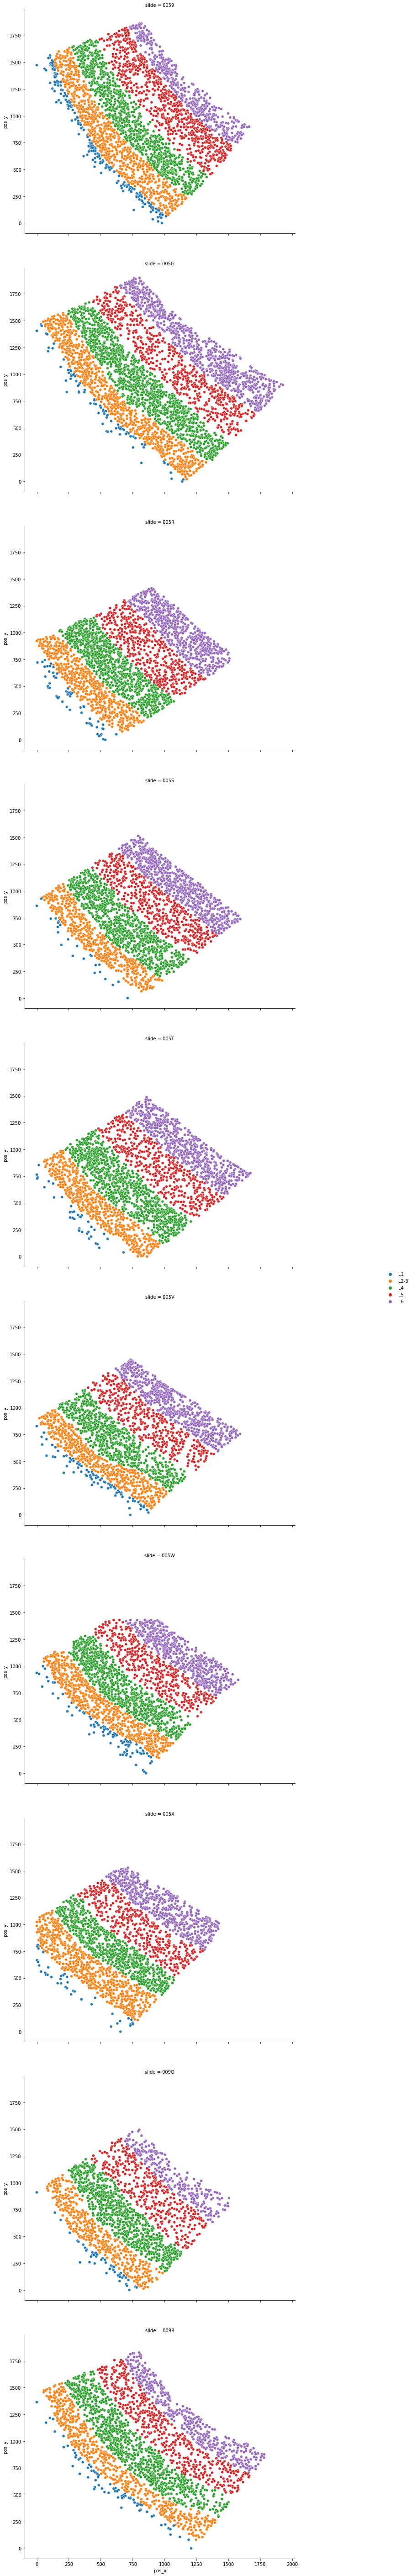

In [ ]:
min_x_map = dict(df.groupby('slide')['PositionX_m'].min())
min_y_map = dict(df.groupby('slide')['PositionY_m'].min())

def visualise_for_each_slide(feature, palette=None):
    g = sns.FacetGrid((df
                        .drop(['TileRow', 'TileColumn', 'Field', 'Neurons_RegressionA_B', 'Neurons_ROINo', 'file'], axis=1)
                        .astype({'slide': 'category', 'layer': 'category'})
                        .rename(columns=column_renaming_map)
                        .assign(
                                pos_x = df['PositionX_m'] - df['slide'].map(min_x_map),
                                pos_y = df['PositionY_m'] - df['slide'].map(min_y_map)
                        )
                    ),
                    row='slide'
                    )
    g.map(sns.scatterplot, 'pos_x', 'pos_y', feature, palette=palette)
    g.add_legend()
    g.fig.set_figwidth(16)
    g.fig.set_figheight(80)

visualise_for_each_slide('layer')

Layer 1 has a lot less neurons than other layers and layer 5 seems to be more sparse compared to other layers (except layer 1)

Looking at spot values will allow us to check staining quality and spot artifacts that could later hinder the accuracy of our machine learning model

In [ ]:
visualise_for_each_slide('spot_rorb', 'magma')

Rorb is specific for layer 4 with some staining in layer 5 as well. Slide 005X seems to have a problem with minimal and non-specific Rorb staining

In [ ]:
visualise_for_each_slide('spot_ctip2', 'magma')

Ctip2 is specific for layer 5 and layer 6. Again, 005X slide seems to have a problem with this staining too.

In [ ]:
visualise_for_each_slide('spot_cux2', 'magma')

Cux2 shows staining predominantly in layer 2-3, and 4. 005X seems to be the odd one out so we have to check it against other slides in other features too.

In [ ]:
visualise_for_each_slide('spot_foxp2', 'magma')

Foxp2 is actually specific for layer 6, with very little extension to layer 5. But only 005G and 0059 slides show the expected staining pattern.

In [ ]:
plt.figure(figsize=(16,16))
sns.kdeplot(data=df[df['slide'] != '005X'], x='Spotcounts_Foxp2', hue='slide')
plt.show()

Checking the distribution, we can clearly tell that those 2 slides show a different distribution than the rest.

In [ ]:
plt.figure(figsize=(16,16))
sns.heatmap(pd.concat([(df
                        .drop(['TileRow', 'TileColumn', 'Field', 'Neurons_RegressionA_B', 'Neurons_ROINo', 'file'], axis=1)
                        .astype({'slide': 'category', 'layer': 'category'})
                        .rename(columns=column_renaming_map)
                        .assign(
                                pos_x = df['PositionX_m'] - df['slide'].map(min_x_map),
                                pos_y = df['PositionY_m'] - df['slide'].map(min_y_map)
                        )
                    )[structure_cols], pd.get_dummies(df['layer'])], axis=1).corr(),
                    annot=True,
                    cmap='RdBu')

In [ ]:
plt.figure(figsize=(16,16))
sns.heatmap(pd.concat([(df
                        .drop(['TileRow', 'TileColumn', 'Field', 'Neurons_RegressionA_B', 'Neurons_ROINo', 'file'], axis=1)
                        .astype({'slide': 'category', 'layer': 'category'})
                        .rename(columns=column_renaming_map)
                        .assign(
                                pos_x = df['PositionX_m'] - df['slide'].map(min_x_map),
                                pos_y = df['PositionY_m'] - df['slide'].map(min_y_map)
                        )
                    )[df['slide'] != '005X'][structure_cols], pd.get_dummies(df[df['slide'] != '005X']['layer'])], axis=1).corr(),
                    annot=True,
                    cmap='RdBu')

In [ ]:
plt.figure(figsize=(16,16))
sns.heatmap(pd.concat([(df
                        .drop(['TileRow', 'TileColumn', 'Field', 'Neurons_RegressionA_B', 'Neurons_ROINo', 'file'], axis=1)
                        .astype({'slide': 'category', 'layer': 'category'})
                        .rename(columns=column_renaming_map)
                        .assign(
                                pos_x = df['PositionX_m'] - df['slide'].map(min_x_map),
                                pos_y = df['PositionY_m'] - df['slide'].map(min_y_map)
                        )
                    )[df['slide'] != '005X'][dapi_cols], pd.get_dummies(df[df['slide'] != '005X']['layer'])], axis=1).corr(),
                    annot=True,
                    cmap='RdBu')

In [ ]:
plt.figure(figsize=(16,16))
sns.heatmap(pd.concat([(df
                        .drop(['TileRow', 'TileColumn', 'Field', 'Neurons_RegressionA_B', 'Neurons_ROINo', 'file'], axis=1)
                        .astype({'slide': 'category', 'layer': 'category'})
                        .rename(columns=column_renaming_map)
                        .assign(
                                pos_x = df['PositionX_m'] - df['slide'].map(min_x_map),
                                pos_y = df['PositionY_m'] - df['slide'].map(min_y_map)
                        )
                    )[df['slide'] != '005X'][alexa_cols], pd.get_dummies(df[df['slide'] != '005X']['layer'])], axis=1).corr(),
                    annot=True,
                    cmap='RdBu')

In [ ]:
plt.figure(figsize=(16,16))
sns.heatmap(pd.concat([(df
                        .drop(['TileRow', 'TileColumn', 'Field', 'Neurons_RegressionA_B', 'Neurons_ROINo', 'file'], axis=1)
                        .astype({'slide': 'category', 'layer': 'category'})
                        .rename(columns=column_renaming_map)
                        .assign(
                                pos_x = df['PositionX_m'] - df['slide'].map(min_x_map),
                                pos_y = df['PositionY_m'] - df['slide'].map(min_y_map)
                        )
                    )[df['slide'] != '005X'][spot_cols], pd.get_dummies(df[df['slide'] != '005X']['layer'])], axis=1).corr(),
                    annot=True,
                    cmap='RdBu')

In [ ]:
plt.figure(figsize=(16,16))
sns.heatmap(pd.concat([(df
                        .drop(['TileRow', 'TileColumn', 'Field', 'Neurons_RegressionA_B', 'Neurons_ROINo', 'file'], axis=1)
                        .astype({'slide': 'category', 'layer': 'category'})
                        .rename(columns=column_renaming_map)
                        .assign(
                                pos_x = df['PositionX_m'] - df['slide'].map(min_x_map),
                                pos_y = df['PositionY_m'] - df['slide'].map(min_y_map)
                        )
                    )[df.slide.isin(['0059', '005G'])][spot_cols], pd.get_dummies(df[df.slide.isin(['0059', '005G'])]['layer'])], axis=1).corr(),
                    annot=True,
                    cmap='RdBu')

In [ ]:
visualise_for_each_slide('wl_ratio', 'magma')

### Normalising values

In [ ]:
from sklearn.preprocessing import PowerTransformer

In [ ]:
transformer = PowerTransformer()

X_new = transformer.fit_transform((df
                        .drop(['TileRow', 'TileColumn', 'Field', 'Neurons_RegressionA_B', 'Neurons_ROINo', 'file'], axis=1)
                        .astype({'slide': 'category', 'layer': 'category'})
                        .rename(columns=column_renaming_map)
                        .assign(
                                pos_x = df['PositionX_m'] - df['slide'].map(min_x_map),
                                pos_y = df['PositionY_m'] - df['slide'].map(min_y_map)
                        )
                        .select_dtypes(['integer', 'float'])
                    ))


In [ ]:
(df
                        .drop(['TileRow', 'TileColumn', 'Field', 'Neurons_RegressionA_B', 'Neurons_ROINo', 'file'], axis=1)
                        .astype({'slide': 'category', 'layer': 'category'})
                        .rename(columns=column_renaming_map)
                        .assign(
                                pos_x = df['PositionX_m'] - df['slide'].map(min_x_map),
                                pos_y = df['PositionY_m'] - df['slide'].map(min_y_map)
                        )
                        .select_dtypes(['integer', 'float'])
                    ).columns

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def normalize_positions(data):
    df_list = []
    for slide in data['slide'].unique():
        interim_df = data[data['slide'] == slide]
        df_list.append(interim_df.assign(
            pos_x = MinMaxScaler().fit_transform(interim_df[['pos_x']]),
            pos_y =  MinMaxScaler().fit_transform(interim_df[['pos_y']])
        ))
    return pd.concat(df_list, axis=0)


In [ ]:
def augment_positions(data):
    df_list = []
    for slide in data['slide'].unique():
        interim_df = data[data['slide'] == slide]

        # original slide
        df_list.append(interim_df)

        # Left-Right flip
        df_list.append(interim_df.assign(
            pos_x = interim_df[['pos_x']].max() - interim_df[['pos_x']],
            slide = slide + '_LR'
        ))

        # Up-Down flip
        df_list.append(interim_df.assign(
            pos_y = interim_df[['pos_y']].max() - interim_df[['pos_y']],
            slide = slide + '_UD'
        ))

        # Left-right and Up-Down flip
        df_list.append(interim_df.assign(
            pos_x = interim_df[['pos_x']].max() - interim_df[['pos_x']],
            pos_y = interim_df[['pos_y']].max() - interim_df[['pos_y']],
            slide = slide + '_LRUD'
        ))

    return pd.concat(df_list, axis=0)


In [ ]:
def normalize_other_values(data):
    associated_columns = ['area', 'roundness', 'wl_ratio', 'alexa_mean',
       'alexa_sum', 'alexa_contrast', 'dapi_mean', 'dapi_median', 'dapi_max',
       'dapi_min', 'dapi_sum', 'dapi_contrast', 'nuclei_object_count',
       'spot_rorb', 'spot_ctip2', 'spot_cux2', 'spot_foxp2']

    for column in associated_columns:
        data[[column]] = MinMaxScaler().fit_transform(data[[column]])

    return data

In [ ]:
df_2 = (
    df
    .drop(['TileRow', 'TileColumn', 'Field', 'Neurons_RegressionA_B', 'Neurons_ROINo', 'file'], axis=1)
    .astype({'slide': 'category', 'layer': 'category'})
    .rename(columns=column_renaming_map)
    .pipe(augment_positions)
    .pipe(normalize_positions)
    .pipe(normalize_other_values)
)

In [ ]:
df_2.describe().T

In [ ]:
df_2.columns

In [ ]:
df_2['slide'].unique()

In [ ]:
slide_groups = [
    ['005R', '005R_LR', '005R_UD', '005R_LRUD'],
    ['005S', '005S_LR', '005S_UD', '005S_LRUD'],
    ['005T', '005T_LR', '005T_UD', '005T_LRUD'],
    ['005V', '005V_LR', '005V_UD', '005V_LRUD'],
    ['005W', '005W_LR', '005W_UD', '005W_LRUD'],
    ['005X', '005X_LR', '005X_UD', '005X_LRUD'],
    ['009Q', '009Q_LR', '009Q_UD', '009Q_LRUD'],
    ['009R', '009R_LR', '009R_UD', '009R_LRUD'],
    ['0059', '0059_LR', '0059_UD', '0059_LRUD'],
    ['005G', '005G_LR', '005G_UD', '005G_LRUD']
]

In [ ]:
sns.scatterplot(x='pos_x', y='pos_y', data=df_2[df_2['slide'] == '005R_LRUD'], hue='layer')

In [ ]:
df_2[['pos_x', 'pos_y']]

In [ ]:
(df
                        .drop(['TileRow', 'TileColumn', 'Field', 'Neurons_RegressionA_B', 'Neurons_ROINo', 'file'], axis=1)
                        .astype({'slide': 'category', 'layer': 'category'})
                        .rename(columns=column_renaming_map)
                        .assign(
                                pos_x = df['PositionX_m'] - df['slide'].map(min_x_map),
                                pos_y = df['PositionY_m'] - df['slide'].map(min_y_map)
                        )).columns

In [ ]:
df_2.info()

In [ ]:
X_new.shape

In [ ]:
normalised_df = pd.DataFrame(data=X_new, columns=(df
                        .drop(['TileRow', 'TileColumn', 'Field', 'Neurons_RegressionA_B', 'Neurons_ROINo', 'file'], axis=1)
                        .astype({'slide': 'category', 'layer': 'category'})
                        .rename(columns=column_renaming_map)
                        .assign(
                                pos_x = df['PositionX_m'] - df['slide'].map(min_x_map),
                                pos_y = df['PositionY_m'] - df['slide'].map(min_y_map)
                        )
                        .select_dtypes(['integer', 'float'])
                    ).columns)

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(15)
axs[0].title.set_text('Distribution of Non-normalised Area Values')
axs[0].hist(x=df['Neurons_NeuronArea_m'], bins=50)
axs[1].title.set_text('Distribution of Normalised Area Values')
axs[1].hist(x=normalised_df['area'], bins=50)
plt.show()

In [ ]:
import xgboost
print(xgboost.__version__)

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [ ]:
def scale_dataframe(dataframe):
    cols = dataframe.columns
    return pd.DataFrame(data=MinMaxScaler().fit_transform(dataframe), columns=cols)

In [ ]:
df.columns

In [ ]:
X = (df
        .drop(['TileRow', 'TileColumn', 'Field', 'Neurons_RegressionA_B', 'Neurons_ROINo', 'file'], axis=1)
        .astype({'slide': 'category', 'layer': 'category'})
        .rename(columns=column_renaming_map)
        .assign(
                pos_x = df['PositionX_m'] - df['slide'].map(min_x_map),
                pos_y = df['PositionY_m'] - df['slide'].map(min_y_map)
        )
        .drop(['layer', 'slide', 'pos_x', 'pos_y'], axis=1)
        ).pipe(scale_dataframe)

In [ ]:
X.columns

In [ ]:
X.describe().T

In [ ]:
X_structural = X[structure_cols]

In [ ]:
X_structural.columns

In [ ]:
Y = df['layer'].map({
    'L1': 1,
    'L2-3': 2,
    'L4': 3,
    'L5': 4,
    'L6': 5
}).astype(int)

In [ ]:
df_w_spot_means = (df
        .drop(['TileRow', 'TileColumn', 'Field', 'Neurons_RegressionA_B', 'Neurons_ROINo', 'file'], axis=1)
        .astype({'slide': 'category', 'layer': 'category'})
        .rename(columns=column_renaming_map)
        .drop(['nuclei_object_count'], axis=1)
        .assign(
                pos_x = df['PositionX_m'] - df['slide'].map(min_x_map),
                pos_y = df['PositionY_m'] - df['slide'].map(min_y_map),
                foxp2_mean = df['Spotcounts_Foxp2'] / df['Neurons_NeuronArea_m'],
                ctip2_mean = df['Spotcounts_Ctip2'] / df['Neurons_NeuronArea_m'],
                cux2_mean = df['Spotcounts_Cux2'] / df['Neurons_NeuronArea_m'],
                rorb_mean = df['Spotcounts_Rorb'] / df['Neurons_NeuronArea_m'],
        ))

In [ ]:
df_w_spot_means.columns

In [ ]:
plt.figure(figsize=(18,18))
sns.heatmap((pd.concat([(df
        .drop(['TileRow', 'TileColumn', 'Field', 'Neurons_RegressionA_B', 'Neurons_ROINo', 'file'], axis=1)
        .astype({'slide': 'category', 'layer': 'category'})
        .rename(columns=column_renaming_map)
        .assign(
                pos_x = df['PositionX_m'] - df['slide'].map(min_x_map),
                pos_y = df['PositionY_m'] - df['slide'].map(min_y_map),
                foxp2_mean = df['Spotcounts_Foxp2'] / df['Neurons_NeuronArea_m'],
                ctip2_mean = df['Spotcounts_Ctip2'] / df['Neurons_NeuronArea_m'],
                cux2_mean = df['Spotcounts_Cux2'] / df['Neurons_NeuronArea_m'],
                rorb_mean = df['Spotcounts_Rorb'] / df['Neurons_NeuronArea_m'],
        )
        .drop(['layer', 'slide', 'pos_x', 'pos_y'], axis=1)
        ), pd.get_dummies(Y)], axis=1))[df.slide.isin(['0059', '005G'])].corr(), annot=True, square=True, cmap='RdYlBu')
plt.show()

In [ ]:
df_w_spot_means.columns

In [ ]:
fig, axs = plt.subplots(ncols=2)
fig.set_figheight(8)
fig.set_figwidth(16)
sns.scatterplot(ax=axs[0], x=df_w_spot_means['pos_x'], y=df_w_spot_means['pos_y'], hue=df_w_spot_means['ctip2_mean'], palette='RdYlGn', size=1)
axs[0].set_title('Mean')
sns.scatterplot(ax=axs[1], x=df_w_spot_means['pos_x'], y=df_w_spot_means['pos_y'], hue=df_w_spot_means['spot_ctip2'], palette='RdYlGn', size=1)
axs[1].set_title('Sum')


In [ ]:
fig, axs = plt.subplots(ncols=2)
fig.set_figheight(8)
fig.set_figwidth(16)
sns.scatterplot(ax=axs[0], x=df_w_spot_means['pos_x'], y=df_w_spot_means['pos_y'], hue=df_w_spot_means['cux2_mean'], palette='RdYlGn', size=1)
axs[0].set_title('Mean')
sns.scatterplot(ax=axs[1], x=df_w_spot_means['pos_x'], y=df_w_spot_means['pos_y'], hue=df_w_spot_means['spot_cux2'], palette='RdYlGn', size=1)
axs[1].set_title('Sum')

In [ ]:
fig, axs = plt.subplots(ncols=2)
fig.set_figheight(8)
fig.set_figwidth(16)
sns.scatterplot(ax=axs[0], x=df_w_spot_means['pos_x'], y=df_w_spot_means['pos_y'], hue=df_w_spot_means['foxp2_mean'], palette='RdYlGn', size=1)
axs[0].set_title('Mean')
sns.scatterplot(ax=axs[1], x=df_w_spot_means['pos_x'], y=df_w_spot_means['pos_y'], hue=df_w_spot_means['spot_foxp2'], palette='RdYlGn', size=1)
axs[1].set_title('Sum')

In [ ]:
fig, axs = plt.subplots(ncols=2)
fig.set_figheight(8)
fig.set_figwidth(16)
sns.scatterplot(ax=axs[0], x=df_w_spot_means['pos_x'], y=df_w_spot_means['pos_y'], hue=df_w_spot_means['rorb_mean'], palette='RdYlGn', size=1)
axs[0].set_title('Mean')
sns.scatterplot(ax=axs[1], x=df_w_spot_means['pos_x'], y=df_w_spot_means['pos_y'], hue=df_w_spot_means['spot_rorb'], palette='RdYlGn', size=1)
axs[1].set_title('Sum')

In [ ]:
df_w_spot_means.columns

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(pd.concat([df_w_spot_means[['area', 'alexa_mean', 'alexa_sum', 'alexa_contrast', 'dapi_mean', 'dapi_median', 'dapi_max', 'dapi_min', 'dapi_sum', 'dapi_contrast']], pd.get_dummies(df_w_spot_means['layer'])], axis=1).corr(), annot=True, cmap='RdYlGn')

In [ ]:
X_train, X_test, Y_train, Y_test  = train_test_split(X_structural,Y, test_size=0.2, random_state=42, stratify=Y)

In [ ]:
df_w_spot_means.columns

In [ ]:
X = df_w_spot_means[['area', 'roundness', 'wl_ratio', 'foxp2_mean', 'ctip2_mean', 'cux2_mean', 'rorb_mean']].pipe(scale_dataframe)
Y = df_w_spot_means['layer']

In [ ]:
X = df_w_spot_means[['pos_x', 'pos_y', 'area', 'roundness', 'wl_ratio', 'alexa_mean',
       'alexa_sum', 'alexa_contrast', 'dapi_mean', 'dapi_median', 'dapi_max',
       'dapi_min', 'dapi_sum', 'dapi_contrast', 'foxp2_mean', 'ctip2_mean',
       'cux2_mean', 'rorb_mean']][df.slide.isin(['005G', '0059'])]
Y = df_w_spot_means['layer'][df.slide.isin(['005G', '0059'])]

In [ ]:
X_train, X_test, Y_train, Y_test  = train_test_split(X,Y, test_size=0.2, random_state=42, stratify=Y)

In [ ]:
X_train = X_train.pipe(scale_dataframe)
X_test = X_test.pipe(scale_dataframe)

In [ ]:
def evaluate_model(model):
    model.fit(X_train, Y_train)
    print('Model fit complete')
    print(model.score(X_test, Y_test))

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
evaluate_model(LogisticRegression(max_iter=1000))

In [ ]:
evaluate_model(SVC())

In [ ]:
evaluate_model(RandomForestClassifier(n_estimators=100))

In [ ]:
#for kernel in ['linear', 'rbf', 'sigmoid']:
#    model = SVC(kernel=kernel)
#    evaluate_model(model)

In [ ]:
cv = GridSearchCV(LogisticRegression(),param_grids['LR_PARAMS'], n_jobs=-1, cv=10, verbose=3)

In [ ]:
cv.fit(X_structural.pipe(scale_dataframe), Y)

In [ ]:
cv.best_score_

In [ ]:
cv = GridSearchCV(RandomForestClassifier(),param_grids['RF_PARAMS'], n_jobs=-1, cv=5, verbose=3)

In [ ]:
cv.fit(X.pipe(scale_dataframe)[df['slide'].isin(['0059', '005G'])], Y[df['slide'].isin(['0059', '005G'])])

In [ ]:
cv.best_score_

In [ ]:
cv.best_params_

In [ ]:
df.columns

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=df[df['slide'] == '0059']['PositionX_m'], y=df[df['slide'] == '0059']['PositionY_m'], hue=df[df['slide'] == '0059']['layer'], palette='Set2', hue_order=['L1', 'L2-3', 'L4', 'L5', 'L6'])

In [ ]:
df[df['slide'] == '0059']['layer'].map({'L1':1, 'L2-3':2, 'L4':3, 'L5':4, 'L6':5}).values.shape[0]

In [ ]:
cv.best_estimator_.predict(X[df['slide'] == '0059'])

In [ ]:
def evaluate_model_on_slide(slide):
    fig, axs = plt.subplots(1,2, figsize=(16,8))
    fig.suptitle(f'Slide {slide}', fontsize=16)
    sns.scatterplot(ax=axs[0], x=df[df['slide'] == slide]['PositionX_m'], y=df[df['slide'] == slide]['PositionY_m'], hue=df[df['slide'] == slide]['layer'].map({'L1':1, 'L2-3':2, 'L4':3, 'L5':4, 'L6':5}), palette='Set2', hue_order=[1,2,3,4,5])
    axs[0].set_title('Original')
    axs[0].axis('off')
    sns.scatterplot(ax=axs[1], x=df[df['slide'] == slide]['PositionX_m'], y=df[df['slide'] == slide]['PositionY_m'], hue=cv.best_estimator_.predict(X[df['slide'] == slide]), palette='Set2', hue_order=[1,2,3,4,5])
    axs[1].set_title('Model Prediction')
    axs[1].axis('off')
    print(f"Model accuracy on this slide is {np.sum(df[df['slide'] == slide]['layer'].map({'L1':1, 'L2-3':2, 'L4':3, 'L5':4, 'L6':5}).values == cv.best_estimator_.predict(X[df['slide'] == slide]))/df[df['slide'] == slide]['layer'].map({'L1':1, 'L2-3':2, 'L4':3, 'L5':4, 'L6':5}).values.shape[0]*100:.3f}")

In [ ]:
evaluate_model_on_slide('0059')

In [ ]:
evaluate_model_on_slide('005G')

In [ ]:
evaluate_model_on_slide('005R')

In [ ]:
df.slide.unique()

In [ ]:
evaluate_model_on_slide('005S')

In [ ]:
evaluate_model_on_slide('005X')

In [ ]:
cv.best_estimator_

In [ ]:
cv = GridSearchCV(SVC(),param_grids['SVC_PARAMS'], n_jobs=-1, cv=5, verbose=3)

In [ ]:
cv.fit(X_structural.pipe(scale_dataframe), Y)

In [ ]:
np.linspace(1e-4, 1, 5)

In [ ]:
model.get_params()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

evaluate_model(RandomForestClassifier())

In [ ]:
d_matrix = xgboost.DMatrix(X_structural, label=Y)

In [ ]:
from sklearn.linear_model import LogisticRegression

evaluate_model(LogisticRegression(max_iter=1000))

In [ ]:
evaluate_model(XGBClassifier())

In [ ]:
cross_val_score(XGBClassifier(), X, Y, cv=10)

In [ ]:
scores = np.array([0.79968454, 0.80126183, 0.79652997, 0.77567141, 0.8056872 , 0.88151659, 0.89257504, 0.87677725, 0.83096367, 0.78041074])


In [ ]:
scores.mean()

In [ ]:
plot_size = (5, 2)
fig, axes = plt.subplots(*plot_size, figsize=(20,30))
#fig.suptitle('Slidewise correlation heatmaps')

set_of_slides = list(set(df['slide']))
feature_name_map = {'Neurons_NeuronArea_m': 'Area', 'Neurons_NeuronRoundness': 'Roundness', 'Neurons_NeuronRatioWidthToLength': 'W/L Ratio'}

for i in range(plot_size[0]):
    for j in range(plot_size[1]):
        # Get the specific slide
        new_df = df[df['slide'] == set_of_slides[i*2 + j]]

        # Get specific columns and rename them
        new_df = new_df[['Neurons_NeuronArea_m', 'Neurons_NeuronRoundness', 'Neurons_NeuronRatioWidthToLength', 'layer']]
        new_df = new_df.rename(columns= feature_name_map)

        # Create dummies for the target variable
        X = new_df.drop('layer', axis=1)
        Y = pd.get_dummies(new_df['layer'])

        # Remove 5 percent tails from either end
        Q1 = X.quantile(0.25)
        Q3 = X.quantile(0.75)
        IQR = Q3 - Q1

        X = X[~((X < (Q1 - 1.5 * IQR)) |(X > (Q3 + 1.5 * IQR))).any(axis=1)]

        # Concatenate X and Y together, visualise correlation heatmap
        new_df = pd.concat([X, Y], axis=1)
        sns.heatmap(new_df.corr(), ax=axes[i,j], cmap='RdYlGn', annot=True)
        axes[i, j].set_title(set_of_slides[i*2 + j])

plt.tight_layout()
fig.savefig('slidewise_corr_heatmaps_without_5percent_tails_fixed.png')

In [ ]:
sns.jointplot(x='Neurons_NeuronArea_m', y='layer',kind='hist', data=df_2[df_2['slide'] == '005X'], palette='magma')

In [ ]:
from scipy import stats
normalized_area, _ = stats.boxcox(df['Neurons_NeuronArea_m'])

In [ ]:
df_2['normalized_area'] = normalized_area

In [ ]:
plt.figure(figsize=(8,8))
sns.kdeplot(df_2['normalized_area'], color='b', shade=True, label='Normalized area')
sns.kdeplot(df_2['Neurons_NeuronArea_m'], color='r', shade=True, label='Non-normalized area')
plt.title('Normalized and non-normalized area distribution')
plt.xlim(0, 250)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,10))

X = df_2.drop('layer', axis=1)

Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

X = X[~((X < (Q1 - 1.5 * IQR)) |(X > (Q3 + 1.5 * IQR))).any(axis=1)]

df_3 = pd.concat([X, pd.get_dummies(df_2['layer'])], axis=1)
df_3 = df_3[['PositionX_m', 'PositionY_m', 'slide','Neurons_NeuronArea_m','normalized_area', 'L1', 'L2-3', 'L4', 'L5', 'L6']]

plt.figure(figsize=(10,10))
sns.heatmap(df_3[df_3['slide'] == '005X'].corr(), cmap='RdYlGn', annot=True)
plt.title('Correlation of structural features with labels')
plt.show()

In [ ]:
plt.figure(figsize=(15,15))
sns.scatterplot(data=df_3[df_3['slide'] == '005X'], x='PositionX_m', y='PositionY_m', hue=df['layer'], size='normalized_area', sizes=(10,300))
plt.title('Visualization of every cell with their corresponding position, label, and area values')
plt.show()

In [ ]:
df_3.columns

In [ ]:
plt.figure(figsize=(15,15))

number_of_bins = 5
use_normalized_area = True
# set of possible filled markers is 'o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'
shapes = ['o', 'o', '^', 'p', 'p']
marker_to_area_map = {k:shapes[k-1] for k in range(1,number_of_bins + 1)}

area_param = 'normalized_area' if use_normalized_area else 'Neurons_NeuronArea_m'
df_2['area_bin'] = (df_2[area_param] / max(df_2[area_param]) * number_of_bins)
df_2['area_bin'] = df_2['area_bin'].apply(int)
# Area bin 5 only has 1 cell in it so maybe try different bin size?

slide_number = '005X'

sns.scatterplot(data=df_2[df_2['slide'] == slide_number], x='PositionX_m', y='PositionY_m', hue=df_2['area_bin'], size='area_bin', sizes=(50,400), style='area_bin', markers=marker_to_area_map, palette='flare')
plt.title('Visualization of every cell with their corresponding position and area values')
plt.show()

In terms of large cells; layers 2-3, and 5 clearly has more of them and layer 4 and 6 less of them

In [ ]:
from sklearn.neighbors import NearestNeighbors

def nearest_neighbors(values, all_values, nbr_neighbors=10):
    nn = NearestNeighbors(n_neighbors = nbr_neighbors, algorithm='ball_tree').fit(all_values)
    dists, idxs = nn.kneighbors(values)
    return dists, idxs

In [ ]:
dists, idxs = nearest_neighbors((pos[0],), pos)

In [ ]:
weighted_sums = []
areas.index = np.arange(len(areas))

for index, cell_pos in enumerate(pos):
    reshaped_pos = (cell_pos, )
    dists, idxs = nearest_neighbors((pos[index],), pos)
    dists = dists[0][1:]
    idxs = idxs[0][1:]
    neighbor_neuron_areas = areas[idxs]
    weighted_sum_of_areas = np.sum(neighbor_neuron_areas / (dists**2))
    weighted_sums.append(weighted_sum_of_areas)

In [ ]:
sns.kdeplot(weighted_sums)

In [ ]:
slide_5X = df_2[df_2['slide'] == '005X']

In [ ]:
slide_5X['weighted_area'] = weighted_sums

In [ ]:
slide_5X['weighted_area'].describe()

In [ ]:
sns.kdeplot(slide_5X['weighted_area'])

In [ ]:
plt.figure(figsize=(15,15))

sns.scatterplot(data=slide_5X, x='PositionX_m', y='PositionY_m', hue=df_2['area_bin'], size='weighted_area', sizes=(25, 500), palette='flare')
plt.title('Visualization of cells on slide 005X with their corresponding position and weighted area sum values')
plt.axis('off')
plt.show()

In [ ]:
from scipy import stats
normalized_weighted_area, _ = stats.boxcox(slide_5X['weighted_area'])

In [ ]:
sns.kdeplot(normalized_weighted_area)

In [ ]:
slide_5X['normalized_weighted_area'] = normalized_weighted_area

In [ ]:
plt.figure(figsize=(15,15))

sns.scatterplot(data=slide_5X, x='PositionX_m', y='PositionY_m', hue=df_2['area_bin'], size='normalized_weighted_area', sizes=(1, 100), palette='flare')
plt.title('Visualization of cells on slide 005X with their corresponding position and normalized weighted area sum values')
plt.axis('off')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=64598117-7413-4d00-8c8a-d6ac0b541e6c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>